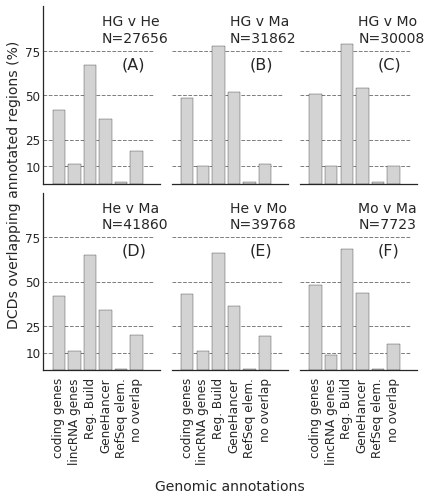

In [1]:
%matplotlib inline

import os as os
import csv as csv
import collections as collect
import operator as op
import itertools as itt
import pickle as pck
import time as ti
import json as js
import string as string

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot HSP overlaps with
# various annotations

date = '20180921'

run_hsp_region_ovl = True

save_figures = True
diss_version = True

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep', 'isect_hsp_any')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'


def read_overlap_table(fpath):
    """
    """
    counter = collect.defaultdict(set)
    hit_regions = set()
    with open(fpath, 'r') as table:
        _ = table.readline()
        for line in table:
            cols = line.strip().split('\t')
            hsp_id = cols[3]
            counter['TOTAL'].add(hsp_id)
            if int(cols[-1]) == 0:
                regtype = 'EMPTY'
            else:
                regtype = cols[10]
                hit_regions.add(regtype)
            counter[regtype].add(hsp_id)
    
    cols = []
    vals = []
    for n, hsps in counter.items():
        cols.append(n)
        vals.append(len(hsps))
    
    s = pd.Series(vals, index=cols, dtype=np.int32)
    
    return s


def cache_hsp_overlaps(cache_file, hsp_region_ovl):
    """
    """
    with pd.HDFStore(cache_file, 'w') as hdf:
        for tsv in os.listdir(hsp_region_ovl):
            # hsp_ovl_reg_ecs10_Mo_vs_Ma_ordem.tsv
            tsv_path = os.path.join(hsp_region_ovl, tsv)
            _, _ , _, seg, c1, _, c2, score = tsv.split('.')[0].split('_')
            comp = c1 + '_vs_' + c2
            store_path = os.path.join(seg, score, comp)
            
            ovl_counts = read_overlap_table(tsv_path)
                  
            hdf.put(store_path, ovl_counts, format='table')
            
    return cache_file


def plot_hsp_overlaps(dataset, fkey, save_diss):
    """
    """
    comparisons = sorted(dataset.keys())
    assert len(comparisons) == 6, '.....'
        
    ncols = 3
    nrows = 2
    
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=nrows, ncols=ncols,
                             sharex=False, sharey=False)
    
    plt.subplots_adjust(hspace=0.05, wspace=0.1)
    
    bar_heights = ['GENES', 'LINCRNA', 'ENSREGB', 'GENEHANCER', 'REFSEQFE', 'EMPTY']
    sub_panel = {i: c for i, c in zip(range(len(comparisons)), string.ascii_uppercase)}
    
    comp_idx = 0
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row, col]
                        
            comp = comparisons[comp_idx]
            panel = sub_panel[comp_idx]
            comp_idx += 1
            
            sub = dataset[comp]
  
            total_hsp = sub['TOTAL']
            yticks = [0.1, 0.25, 0.5, 0.75]
            yticklabels = ['10', '25', '50', '75']
            
            ax.set_ylim(0, 1)
            ax.set_xlim(0, 7.5)
                        
            data_x = np.arange(1,7,1)
            data_y = sub[bar_heights].values
            data_y = data_y / total_hsp
            
            bars = ax.bar(data_x, data_y, align='center',
                          color='lightgrey', edgecolor='black')
            
            label = ' v '.join(comp.split('_vs_')) + '\nN={}'.format(total_hsp)
            ax.text(0.5, 0.8, s=label,
                    fontdict={'fontsize': 14},
                    transform=ax.transAxes)
            ax.text(5, 0.65, s='({})'.format(panel),
                    fontdict={'fontsize': 16})
                
            
            if col == 0:
                ax.set_yticks(yticks)
                ax.set_yticklabels(yticklabels, fontsize=12)
                ax.tick_params(axis='y', which='major', pad=3)
            else:
                ax.set_yticks([])
                
            for y in yticks:
                ax.axhline(y, 0, 0.95, ls='dashed', lw=1, color='grey', zorder=0)
            
            if row == 1:
                ax.set_xticks(data_x)
                ax.set_xticklabels(['coding genes', 'lincRNA genes', 'Reg. Build',
                                    'GeneHancer', 'RefSeq elem.', 'no overlap'],
                                   rotation=90, fontsize=12)
            else:
                ax.set_xticks([])
            
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if col != 0:
                ax.spines['left'].set_visible(False)
                
            if row == 0 and col == 0:
                yl = ax.set_ylabel('DCDs overlapping annotated regions (%)', fontsize=14)
                yl.set_position((-0.25, 0.))
                
                if not save_diss:
                    tt = ax.set_title(fkey, fontsize=18)
                    tt.set_position((0.025, 1.01))
                
            if row == 1 and col == 1:
                xl = ax.set_xlabel('Genomic annotations',
                                   fontsize=14, labelpad=15, zorder=3)
            
            
    return fig, []


def plot_hsp_region_overlap():
    cache_file = os.path.join(cache_dir, '{}_plot_hsp_ovl_region.h5'.format(date))
    if (not os.path.isfile(cache_file)) or os.stat(cache_file).st_size < 10:
        print('Caching')
        _ = cache_hsp_overlaps(cache_file, isect_root)

    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())
        for seg in segmentations:
            if seg != 'cmm18':
                continue
            for score in scorings:
                if score not in ['penem']:
                    continue
                load_keys = [k for k in cached_keys if seg in k and score in k]
                plot_data = dict()
                for k in load_keys:
                    comp = os.path.split(k)[-1]
                    if comp == 'Liver_vs_Blood':
                        continue
                    plot_data[comp] = hdf[k]
                if score == 'penem':
                    fk = '4'
                    out_folder = fig_main
                elif score == 'ordem':
                    fk = 'SX'
                    out_folder = fig_supp
                else:
                    raise
                fig, exart = plot_hsp_overlaps(plot_data, fk, diss_version)

                if save_figures:
                    outname = 'fig_{}_hsp_region_ovl_{}_{}'.format(fk, seg, score)
                    if diss_version:
                        out_folder = fig_diss

                    out_pdf = os.path.join(out_folder, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                    
                    if not diss_version:
                        out_png = os.path.join(out_folder, outname + '.png')
                        fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                
    return



if run_hsp_region_ovl:
    plot_hsp_region_overlap()
